In [1]:
import numpy as np
import os 

from sklearn.linear_model import SGDClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [2]:
def get_data(): 
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    data = mnist['data']
    labels = mnist['target']
    return data, labels

In [3]:
data, labels = get_data()

In [4]:
def split_data(data, labes): 
    X_train = data[60000:]
    Y_train = labels[60000:]
    X_test = data[:60000]
    Y_test = labels[:60000]
    
    random_index = np.random.permutation(60000)
    X_train, Y_train = data[random_index], labels[random_index]
    data_dict = {'X_train':X_train, 'Y_train':Y_train, 'X_test':X_test, 'Y_test':Y_test}
    return data_dict

In [13]:
data_dict = split_data(data, labels)
data_dict.keys()

['X_test', 'X_train', 'Y_train', 'Y_test']

In [6]:
SDG = SGDClassifier(random_state=14)
SDG.fit(data_dict['X_train'], data_dict['Y_train'])

/opt/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=14, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

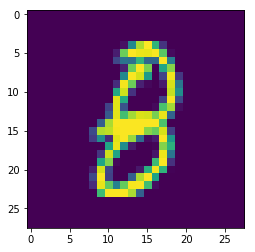

In [7]:
some_image = (data_dict['X_train'])[25]
image = some_image.reshape(28,28)
plt.imshow(image)

In [8]:
SDG.predict([some_image])

array(['8'], dtype='|S1')

In [9]:
from sklearn.externals import joblib
joblib.dump(SDG, 'models/SDG_image_classifier.pkl')

['models/SDG_image_classifier.pkl']

# Model Evaluation

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
print (data_dict['Y_train'])[7]

5


In [11]:
skfolds = StratifiedKFold(n_splits=3, random_state=19)
for train_index, test_index in skfolds.split(data_dict['X_train'], data_dict['Y_train']):
    clone_SDG = clone(SDG)
    x_train_folds = (data_dict['X_train'])[train_index]
    y_train_folds = (data_dict['Y_train'])[train_index]
    x_test_folds = (data_dict['X_train'])[test_index]
    y_test_folds = (data_dict['Y_train'])[test_index]
    
    clone_SDG.fit(x_train_folds, y_train_folds)
    y_pred = clone_SDG.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print n_correct/float(len(y_pred))

0.8725754849030194
0.8671433571678584
0.8791818772815923


## Confusion Matrix

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(SDG, data_dict['X_train'], data_dict['Y_train'], cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(data_dict['Y_train'], y_train_pred)

In [14]:
import pandas as pd
pd.DataFrame(con_mat)

,0,1,2,3,4,5,6,7,8,9
0,5699,2,32,19,15,36,59,6,51,4
1,1,6514,34,23,6,26,13,8,107,10
2,62,116,5036,186,68,45,116,62,250,17
3,50,79,278,4898,16,471,33,37,210,59
4,16,31,76,64,5104,39,76,35,88,313
5,68,40,45,297,70,4417,126,18,261,79
6,51,21,68,13,46,105,5575,7,28,4
7,20,52,92,78,85,34,4,5619,53,228
8,46,219,133,350,45,390,47,29,4500,92
9,40,31,54,127,232,151,4,226,68,5016


This confusion matrix shows that 0 is wrongly classified as 2 44 times, as 3, 8 times ect.

True Positive: correctly predicted that the var was the target value
True Negative: correctly predicted that the var was not the target value
False Positive: incorrectly predicted that the var was the target value 
False Negative: incorrectly predicted that the var was not the target value.

***Precision:***
* TP/TP + FP the accuracy of the positive predictions. ***The ratio of predicted 5s that were actually 5s***


***Recall:***

* TP/TP+FN also known as sensitivity or true positive rate. ***The ratio of 5s that were positively classified***

In [15]:
from sklearn.metrics import precision_score, recall_score
y_train_pred.shape

(60000,)

In [16]:
data_dict['Y_train'].shape

(60000,)

In [17]:
precision_score(data_dict['Y_train'], y_train_pred, average='macro')

0.8711995896825195

In [18]:
recall_score(data_dict['Y_train'], y_train_pred, average='macro')

0.8712167071353866

This means that when the model predicts a value. it is correct 86.5% of the time. 
the recall score means it correctly indetifies 86.2% of the values. Not bad.  
<br/>
The f1 score combines both these metrics. It is the harmonic mean of precision and recall. The metric gives a much larger weight to lower values and therefore the score will only be high if both the precision and recall are high. 

In [19]:
from sklearn.metrics import f1_score 
f1_score(data_dict['Y_train'], y_train_pred, average='macro')

0.8709673481219425

f1 score is high when the recall and precision are equal. This however may not always be what you want.
<br/>  
A trade of must be made between precision and recall. If you alter the prediction threshold one will be increased while the other decreasees. You may want to alter this threshold as for example suppose you trained a model to predict videos that were safe for children to watch. You would want the precision to be very high but be too concerened the the recall was low. As the reprocussions would would not be as bad if a few suitible videos were flagged as long as all the unsuitible videos were discarded. 
<br/>  
The SGDClassier does not allow you to directly set thresholds but does give access to the function that provides the output on which the classifications are made. 

In [20]:
SGD = joblib.load('models/SDG_image_classifier.pkl')
y_scores = SGD.decision_function([some_image])
y_scores

array([[-326889.31438725, -346858.01793287,  -82527.20390068,
        -198339.28705532, -431069.15268466, -368434.47647194,
        -192588.56859052, -632322.34554782,  195207.57713486,
        -236306.45787968]])

In [21]:
threshold = 2000
ar = np.linspace(0, 9, num=10)
choice = (y_scores>threshold)[0]
ar[choice]

array([8.])

## Binary Classifier and the precision recall curve

In [22]:
bin_clas = SGDClassifier(random_state=19)

In [23]:
bin_target = (data_dict['Y_train']=='5')
bin_clas.fit(data_dict['X_train'], bin_target)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=19, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
some_im = data_dict['X_train'][9]
bin_clas.predict([some_im]) #image not predicted to be 5

array([False])

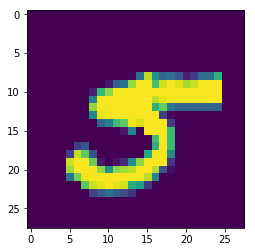

In [25]:
plt.imshow(some_im.reshape(28,28))

In [26]:
y_scores = bin_clas.decision_function([some_im])
y_scores

array([-81128.23097826])

In [27]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(bin_clas, data_dict['X_train'], bin_target, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(bin_target, y_scores)

In [28]:
def plt_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("Threshold")
    plt.ylim(0,1)
    plt.legend()


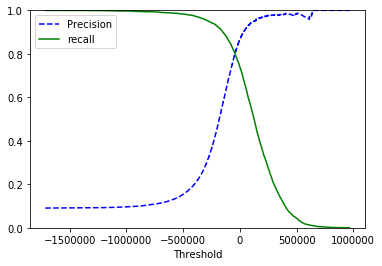

In [29]:
plt_precision_recall(precisions, recalls, thresholds)

In [30]:
joblib.dump(bin_clas, "models/num5classifier.pkl")

['models/num5classifier.pkl']

## ROC curve
The receiver operating curve plots the True positive rate against the False Positive rate

In [31]:
from sklearn.metrics import roc_curve
TPR, FPR, thresholds = roc_curve(bin_target, y_scores)

In [32]:
def plt_roc_curve(FPR, TPR, label=None): 
    plt.plot(FPR, TPR, label=label)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True Positive rate")

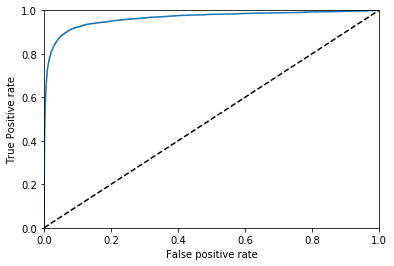

In [33]:
plt_roc_curve(TPR, FPR)

As you can see the higher the TPR the more false positives you will get. The best models will stay as far away from the dotted line as possible. A way to measure the performance of these models is to measure the arear under the graph. The higher it is the better the model is.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(bin_target, y_scores)

0.9641037889534129

### Lets train a RandomForestClassifier and comapare to the SGDClassifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
ran_forest = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(ran_forest, data_dict['X_train'], bin_target, cv=3, method="predict_proba")


/opt/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:
y_scores_forest = y_proba_forest[:,1]
pd.DataFrame(y_proba_forest).head() #the table has a row per instance and a columns per prediction e.g.
# the first row is the prediction of a single instance. There is 0% chance it is a 5 and 100% it is not.

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [37]:
y_scores_forest = y_proba_forest[:,1] #the second column probablity that the value is a 5

In [38]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(bin_target, y_scores_forest)

In [39]:
def plt_two_roc_curve(FPR, TPR, FPR2, TPR2, label=None, label2=None): 
    plt.plot(FPR, TPR, label=label)
    plt.plot(FPR2, TPR2, "g--", label=label2)
    plt.plot([0,1], [0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False positive rate")
    plt.ylabel("True Positive rate")
    plt.show()

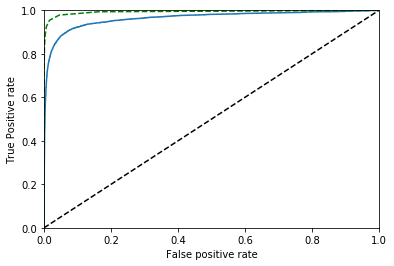

In [40]:
plt_two_roc_curve(TPR, FPR, fpr_forest, tpr_forest, label="SGDC", label2="RandomForest")

As you can see the ensemble algorithm is much more effective. lets check its AUC score

In [41]:
roc_auc_score(bin_target, y_scores_forest)

0.9932215709659165

***99 wow that's pretty good lets save this one.***

In [42]:
joblib.dump(ran_forest, "models/forest_num5classifier.pkl")

['models/forest_num5classifier.pkl']

In [43]:
y_train_pred = cross_val_predict(ran_forest, data_dict['X_train'], bin_target, cv=3)
precision_score(bin_target, y_train_pred)

0.9862535457124154

In [44]:
recall_score(bin_target, y_train_pred)

0.833794502859251

# Multiclass Classifier
There are some classifiers that are strictly binary e.g. support vector machines or linear classifiers. a way to get roung this for multiclass is to train a model for each class and pick the prediction from the set of them that is the highest. This iscalled the one-versus-all method. 
<br/>  
another method using the above example would be to train a classifier for every pair of digit. e.g. 0 vs 1, 0 vs 2, 0 vs 3. This would of course dramaticaly increase the number of models you would have to train. N*(N-1)/2 classifiers would be needed for each of the N classes. The datasets you would have to train them with though would be significantly reduced. This method is particuarly good for Support Vector Machine models as they do not scale very well with the size of the dataset. 
<br/>   
Some of Sci-kit Learn models automatically use the OVA model when you use multiclass training data apart from Support Vector Machines which use OVO due to scaling issues. Should you want Sci-kit learn to use a specific method for multiclass training you can specify it as follows

In [45]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(data_dict['X_train'], data_dict['Y_train'])

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [46]:
ovo_clf.predict([some_image])

array(['8'], dtype=object)

In [47]:
len(ovo_clf.estimators_) #as you can see 10*(10-1)/2 models are needed for 10 classes

45

We can check the accuracy as below and possibly improve it by simply using a standard scaler

In [48]:
from sklearn.model_selection import cross_val_score


In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(data_dict['X_train'].astype(np.float64))

In [50]:
cross_val_score(ovo_clf, X_train_scaled, data_dict['Y_train'], cv=3, scoring='accuracy')

array([0.91656669, 0.91834592, 0.91883783])

This is slightly better once scaled.

### Error Analysis


In [51]:
y_train_predict = cross_val_predict(ovo_clf, X_train_scaled, data_dict['Y_train'], cv=3)
conf_mx = confusion_matrix(data_dict['Y_train'], y_train_predict)
conf_mx

array([[5627,    1,   50,   13,    9,  104,   55,    6,   41,   17],
       [   2, 6481,   51,   37,    5,   44,    3,   16,   91,   12],
       [  22,   36, 5458,  116,   65,   25,   64,   55,  104,   13],
       [  23,   14,  149, 5426,    4,  252,   14,   60,  145,   44],
       [   6,   18,   75,    9, 5348,   14,   43,   49,   49,  231],
       [  25,   12,   40,  168,   26, 4826,   70,   10,  209,   35],
       [  33,   12,   82,    7,   34,  113, 5599,    6,   32,    0],
       [  11,   20,   79,   44,   44,   12,    3, 5834,   25,  193],
       [  30,   58,   89,  174,   20,  148,   30,   19, 5213,   70],
       [  16,   24,   30,   55,  170,   49,    1,  262,   79, 5263]])

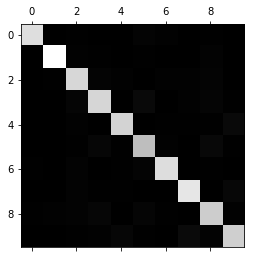

In [52]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [53]:
# lets just look at the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
conf_mx_norm = conf_mx / row_sums.astype(np.float)
# now fill the diaganol with 0
np.fill_diagonal(conf_mx_norm, 0)


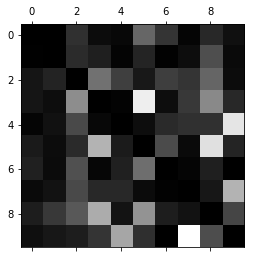

In [54]:
plt.matshow(conf_mx_norm, cmap=plt.cm.gray)

As you can see here the some digits are commonly mistaken for others. e.g. 5 for 3, 5 for 8 ect.

# Lets see what accuracy we can get with KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score

def KNN_finetune(): #This takes a long time
    param_grid = [
    {'n_neighbors':[2, 5], 'weights': ['uniform', 'distance']}
    ]

    grid_search = GridSearchCV(KNN, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(data_dict['X_train'], data_dict['Y_train'])
    print('Best Params:  ', grid_search.best_params_)
    KNN_tuned = grid_search.best_estimator_
    acc = cross_val_score(KNN_tuned, data_dict['X_train'], data_dict['Y_train'], scoring='accuracy', cv=3)
    joblib.dump(KNN_tuned, 'MNIST_KNNC_tuned.pkl')
    return acc, KNN_tuned



In [19]:
def add_image_shift(X_train, Y_train): 
    samp_range = np.arange(60000)
    rand_index = np.random.permutation(samp_range)
    
    left = X_train[rand_index[:15000]]
    right = X_train[rand_index[15000:30000]]
    up = X_train[rand_index[30000:45000]]
    down = X_train[rand_index[45000:60000]]
    
    samps = [left, right, up, down]
    samps_shift = [left, right, up, down]
    
    samps_shift[0] = np.roll(samps[0], 3)
    samps_shift[1] = np.roll(samps[1], -3)
    samps_shift[2] = np.roll(samps[2], 3, axis=1)
    samps_shift[3] = np.roll(samps[3], -3, axis=1)
    
    samp_shift_con = np.concatenate(samps_shift)
    
    final_X = np.concatenate((X_train, samp_shift_con), axis=0)
    
    random_y = Y_train[rand_index]
    final_Y = np.concatenate((Y_train, random_y), axis=0)
    
    return final_X, final_Y
    
    

In [20]:
KNN = KNeighborsClassifier()
KNN.fit(data_dict['X_train'], data_dict['Y_train'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [23]:
pred = KNN.predict(data_dict['X_test'][:500])
score = f1_score(data_dict['Y_test'][:500], pred, average='macro')

In [24]:
score

0.9802812648760744